# Train LSTM model to Enduro sequence games

## Load libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import csv
import os
import cv2
from PIL import Image
from enduro_lstm import *

## Set to GPU if available

In [3]:
device = conf_cuda(True)

GPU is available


## Set configurations

In [36]:
obs = 'zigzag'
if obs == 'zigzag':
    zigzag = True

In [29]:
data_path = r"../1-generate/data/"
n_epochs = 10
match = 35
hidden_neurons = 200

model_path = ""
stop_train = 1e-5

## Load frames and targets

In [37]:
ACTIONS_LIST = get_actions_list(zigzag=zigzag)

In [19]:
num_of_frames, frames, actions, rewards, lifes = load_npz(data_path, match)

Successfully loaded NPZ.


In [20]:
X_train = frames.reshape(1, len(frames) ,-1)/255

In [21]:
action_one_hot = [prepare_action_data(i, ACTIONS_LIST) for i in actions]
Y_train = np.array(action_one_hot)
Y_train = Y_train.reshape(1, len(Y_train), -1)

In [22]:
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()

In [23]:
model = Model(device=device, input_size=20400, output_size=2, hidden_dim=hidden_neurons, n_layers=1)

In [24]:
# We'll also set the model to the device that we defined earlier (default is CPU)
model.cuda()
X_train = X_train.cuda() 
Y_train = Y_train.cuda()

In [25]:
min_loss = 1e-05
# Define Loss, Optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters())

In [26]:
loss_arr = np.array([])

In [27]:
model_name = f"{obs}_m{match}to{match}_f{1}to{120}_epoch{n_epochs}_H{hidden_neurons}"
newpath = f"models/" + model_name
if not os.path.exists(newpath):
    print(f"models/" + model_name)
    os.makedirs(newpath)
else:
    print(f"models/" + model_name)
    print("ATTENTION! folder not created. Training informations will overwrite the existing one")

models/zigzag_m35to35_f1to120_epoch2000_H200
ATTENTION! folder not created. Training informations will overwrite the existing one


In [30]:
import time
# Training Run

model.train()

epoch = 1
loss_file = open(newpath + '/' + "loss_file.txt", "w")

start_time_processing = time.time()
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    X_train.to(device)
    output, hidden = model(X_train)
    loss = criterion(output, Y_train.view(-1,2).float())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordinglyw
    
    if epoch%10 == 0:
        acc = float((torch.sum((torch.argmax(output, axis=1) == torch.argmax(Y_train.squeeze(), axis=1)).int())/120))
        
        loss_file.write("Epoch: {}/{}.............".format(epoch, n_epochs))
        loss_file.write("Loss: {:.15f} Acc: {:.15f}\n".format(loss.item(), acc))
        
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.15f} Acc: {:.15f}".format(loss.item(), acc))
        
        loss_arr = np.append(loss_arr, loss.item())
        
        if loss.item() < min_loss:
            break;

loss_file.close()
np.savez("loss_arr", loss_arr)
print("--- %s seconds ---" % (time.time() - start_time_processing))

Epoch: 10/10............. Loss: 0.150938585400581 Acc: 0.941666722297668
--- 1.8945140838623047 seconds ---


In [31]:
torch.save(model.state_dict(), newpath + '/' + model_name)

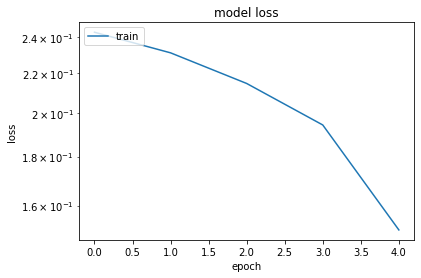

In [32]:
import matplotlib.pyplot as plt
# summarize history for loss
g = list(loss_arr)
plt.plot(loss_arr)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.yscale('log')
plt.savefig(newpath + '/' + 'perf.png')
plt.show()

In [33]:
model.eval() # eval mode
out, hidden = model(X_train)

In [34]:
for i in range(120):
    print(str(i) + "->" + str(out[i]))

0->tensor([0.7419, 0.2901], device='cuda:0', grad_fn=<SelectBackward>)
1->tensor([0.7063, 0.3187], device='cuda:0', grad_fn=<SelectBackward>)
2->tensor([0.6384, 0.3819], device='cuda:0', grad_fn=<SelectBackward>)
3->tensor([0.6401, 0.3724], device='cuda:0', grad_fn=<SelectBackward>)
4->tensor([0.7182, 0.3069], device='cuda:0', grad_fn=<SelectBackward>)
5->tensor([0.7304, 0.2968], device='cuda:0', grad_fn=<SelectBackward>)
6->tensor([0.7119, 0.3132], device='cuda:0', grad_fn=<SelectBackward>)
7->tensor([0.7205, 0.3066], device='cuda:0', grad_fn=<SelectBackward>)
8->tensor([0.7686, 0.2650], device='cuda:0', grad_fn=<SelectBackward>)
9->tensor([0.7670, 0.2649], device='cuda:0', grad_fn=<SelectBackward>)
10->tensor([0.7516, 0.2791], device='cuda:0', grad_fn=<SelectBackward>)
11->tensor([0.7497, 0.2806], device='cuda:0', grad_fn=<SelectBackward>)
12->tensor([0.7294, 0.2984], device='cuda:0', grad_fn=<SelectBackward>)
13->tensor([0.7360, 0.2918], device='cuda:0', grad_fn=<SelectBackward>)
14